<a href="https://colab.research.google.com/github/Haniya16/FutureSalesPrediction/blob/main/Future_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Future Sales
### Objective
To build and compare regression models for predicting future product sales using Linear Regression, Random Forest, and XGBoost (or LightGBM).

**Why:** Forecasting helps businesses with inventory planning and marketing strategies.

**Evaluation Metrics:** RMSE, MAE, R²  
**Tools:** scikit-learn, xgboost/lightgbm, pandas, matplotlib

## Mount Google Drive

In [1]:
# Mount Google Drive & set folder paths
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set folder paths

In [ ]:
import os

project_path = "/content/drive/MyDrive/Colab Notebooks/FutureSalesPrediction"
dataset_path = os.path.join(project_path, "Dataset")

# Move to dataset folder
%cd $dataset_path

print("Drive mounted successfully")
print("Project folder:", project_path)
print("Dataset folder:", dataset_path)

/content/drive/MyDrive/Colab Notebooks/FutureSalesPrediction/Dataset
Drive mounted successfully
Project folder: /content/drive/MyDrive/Colab Notebooks/FutureSalesPrediction
Dataset folder: /content/drive/MyDrive/Colab Notebooks/FutureSalesPrediction/Dataset


## Install updated ML libraries

In [ ]:
# Install updated ML libraries
!pip install lightgbm xgboost --quiet

# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import gc

# Machine Learning models and utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print("Libraries installed and imported successfully!")

Libraries installed and imported successfully!


## Load all CSV files from dataset folder

In [ ]:
# Load all CSV files from your dataset folder
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FutureSalesPrediction/Dataset/train.csv', parse_dates=['date'])
stores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FutureSalesPrediction/Dataset/stores.csv')
oil = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FutureSalesPrediction/Dataset/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FutureSalesPrediction/Dataset/holidays_events.csv', parse_dates=['date'])

# Quick check
print("train:", train.shape)
print("stores:", stores.shape)
print("oil:", oil.shape)
print("holidays:", holidays.shape)

train: (3000888, 6)
stores: (54, 5)
oil: (1218, 2)
holidays: (350, 6)


## Merge and Preprocess Data

In [ ]:
# Merge datasets
df = train.merge(stores, how='left', on='store_nbr')
df = df.merge(oil[['date', 'dcoilwtico']], how='left', on='date')

holidays['is_holiday'] = 1
df = df.merge(holidays[['date', 'is_holiday']], how='left', on='date')
df['is_holiday'] = df['is_holiday'].fillna(0)

# Fill missing values
df['dcoilwtico'] = df['dcoilwtico'].fillna(method='ffill')
df['onpromotion'] = df['onpromotion'].fillna(0)

# Create time-based features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['dayofweek'] = df['date'].dt.dayofweek
df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)

# Encode categorical features
le_store = LabelEncoder()
df['store_nbr_enc'] = le_store.fit_transform(df['store_nbr'])

le_family = LabelEncoder()
df['family_enc'] = le_family.fit_transform(df['family'])

le_type = LabelEncoder()
df['type_enc'] = le_type.fit_transform(df['type'])

le_state = LabelEncoder()
df['state_enc'] = le_state.fit_transform(df['state'])

print("Data merged and preprocessed successfully!")
df.head()


Data merged and preprocessed successfully!


,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,is_holiday,year,month,day,dayofweek,weekofyear,store_nbr_enc,family_enc,type_enc,state_enc
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,...,1.0,2013,1,1,1,1,0,0,3,12
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,...,1.0,2013,1,1,1,1,0,1,3,12
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,...,1.0,2013,1,1,1,1,0,2,3,12
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,...,1.0,2013,1,1,1,1,0,3,3,12
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,...,1.0,2013,1,1,1,1,0,4,3,12


## Feature Selection and Splitting

In [ ]:
# Define features and target
X = df.drop(columns=['sales'])
y = df['sales']

# Split data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=['float64', 'int64']))
X_valid_scaled = scaler.transform(X_valid.select_dtypes(include=['float64', 'int64']))

# Replace scaled columns back in DataFrame (optional)
X_train[X_train.select_dtypes(include=['float64', 'int64']).columns] = X_train_scaled
X_valid[X_valid.select_dtypes(include=['float64', 'int64']).columns] = X_valid_scaled

print("Feature scaling and split completed successfully.")

Feature scaling and split completed successfully.


## Remove or Convert the date Column

In [ ]:
# Handle 'date' column before training
if 'date' in X_train.columns:
    # Option 1: Convert date to numeric features
    X_train['year'] = pd.to_datetime(X_train['date']).dt.year
    X_train['month'] = pd.to_datetime(X_train['date']).dt.month
    X_train['day'] = pd.to_datetime(X_train['date']).dt.day
    X_valid['year'] = pd.to_datetime(X_valid['date']).dt.year
    X_valid['month'] = pd.to_datetime(X_valid['date']).dt.month
    X_valid['day'] = pd.to_datetime(X_valid['date']).dt.day

    # Drop the original date column
    X_train = X_train.drop(columns=['date'])
    X_valid = X_valid.drop(columns=['date'])

print("Date column handled successfully.")

Date column handled successfully.


## Verify all features are numeric

In [ ]:
X_train = X_train.select_dtypes(include=['int64', 'float64'])
X_valid = X_valid.select_dtypes(include=['int64', 'float64'])

## Train Multiple Models and Compare Results

In [ ]:
# Models dictionary
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(
        n_estimators=60,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    ),
    "XGBoost": XGBRegressor(
        n_estimators=120,
        learning_rate=0.08,
        max_depth=8,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    ),
    "LightGBM": LGBMRegressor(
        n_estimators=120,
        learning_rate=0.08,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    )
}
# To store results safely
results = {}

# Loop through models one by one
for name, model in models.items():
    print(f"\nTraining {name}")

    # Train model
    model.fit(X_train, y_train)

    # Predict on validation data
    y_pred = model.predict(X_valid)

    # Compute evaluation metrics
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    mae = mean_absolute_error(y_valid, y_pred)
    r2 = r2_score(y_valid, y_pred)

    # Save results
    results[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

    print(f"{name} Completed | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")

    # Clean up to avoid crash
    del model, y_pred
    gc.collect()

print("\nAll models trained successfully without crash!")


Training Linear Regression
Linear Regression Completed | RMSE: 979.1190 | MAE: 426.2927 | R²: 0.1991

Training Random Forest
Random Forest Completed | RMSE: 436.1593 | MAE: 136.2158 | R²: 0.8411

Training XGBoost
XGBoost Completed | RMSE: 365.9865 | MAE: 116.2117 | R²: 0.8881

Training LightGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.276940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 954
[LightGBM] [Info] Number of data points in the train set: 2442073, number of used features: 11
[LightGBM] [Info] Start training from score 359.589532
LightGBM Completed | RMSE: 431.2936 | MAE: 148.2893 | R²: 0.8446

All models trained successfully without crash!


## Evaluation Metrics & Comparison Table


Model Evaluation Summary:



,RMSE,MAE,R2
XGBoost,365.986485,116.211658,0.888093
LightGBM,431.293556,148.289333,0.844592
Random Forest,436.159334,136.215758,0.841066
Linear Regression,979.119039,426.292688,0.199063


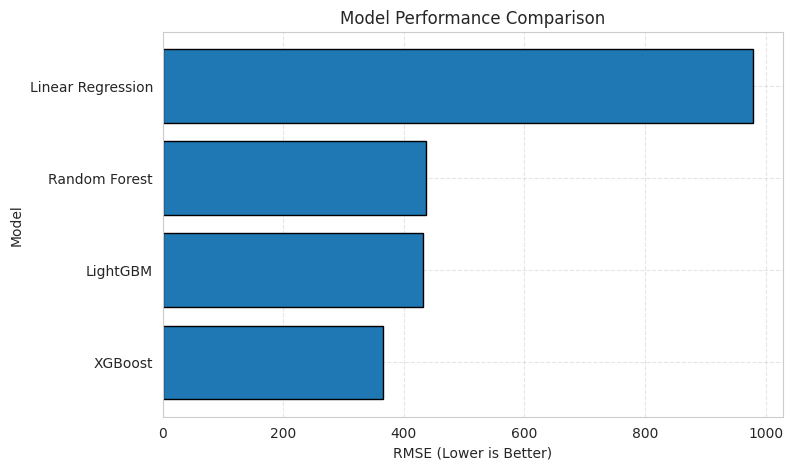

In [ ]:
# Compare Model Performance
# Convert results dictionary to DataFrame
results_df = pd.DataFrame(results).T.sort_values(by="RMSE")

print("\nModel Evaluation Summary:\n")
display(results_df)

# Plot comparison
plt.figure(figsize=(8, 5))
plt.barh(results_df.index, results_df["RMSE"], edgecolor='black')
plt.xlabel("RMSE (Lower is Better)")
plt.ylabel("Model")
plt.title("Model Performance Comparison")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

## Feature Importance for Best Model (XGBoost)

Retraining Best Model: XGBoost for Feature Importance...

🔍 Top 11 Important Features for Future Sales Prediction:



,Feature,Importance
2,onpromotion,0.302857
9,type_enc,0.218977
8,family_enc,0.194692
1,store_nbr,0.076626
0,id,0.067188
3,cluster,0.051697
10,state_enc,0.040508
6,weekofyear,0.022265
5,is_holiday,0.013342
4,dcoilwtico,0.011848


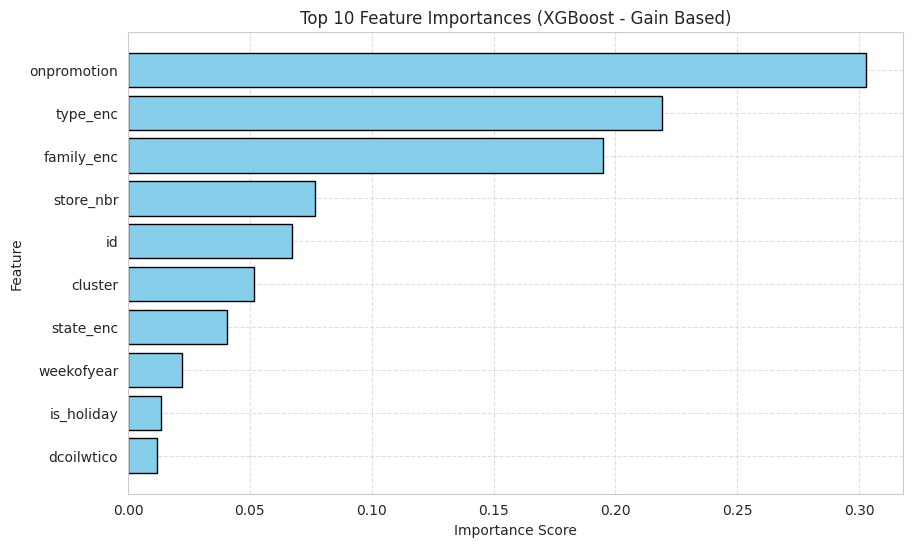

In [ ]:
# Feature Importance for Best Model (XGBoost)

print("Retraining Best Model: XGBoost for Feature Importance...")

best_model = XGBRegressor(
    n_estimators=120,
    learning_rate=0.08,
    max_depth=8,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
best_model.fit(X_train, y_train)

# Extract importance values (gain type — correct one)
importances = best_model.feature_importances_
features = X_train.columns

feat_imp = pd.DataFrame({"Feature": features, "Importance": importances})
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

# Display exact top 11 table
print("\n🔍 Top 11 Important Features for Future Sales Prediction:\n")
display(feat_imp.head(11))

# ✅ Custom Matplotlib Plot that matches this table exactly
plt.figure(figsize=(10, 6))
plt.barh(feat_imp["Feature"].head(10), feat_imp["Importance"].head(10), color="skyblue", edgecolor="black")
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (XGBoost - Gain Based)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Feature Correlation Heatmap Visualization

Generating Correlation Heatmap...


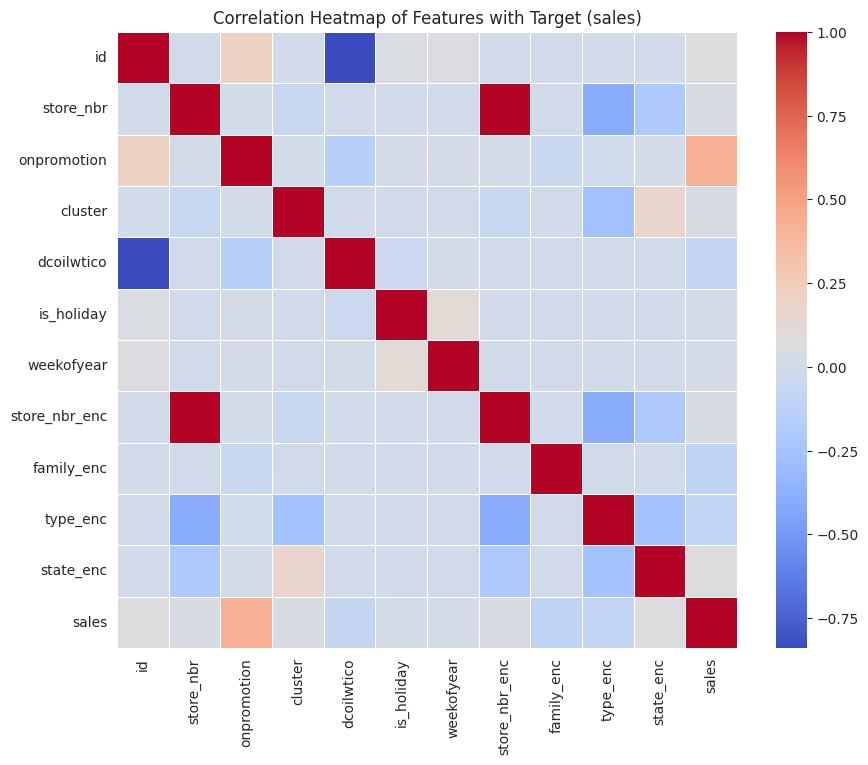

In [ ]:
# Feature Correlation Heatmap Visualization

print("Generating Correlation Heatmap...")

# Combine X and y for correlation
corr_df = pd.concat([X_train, y_train], axis=1)
corr_df.rename(columns={y_train.name: "sales"}, inplace=True)

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Correlation Heatmap of Features with Target (sales)")
plt.show()


## Insight Summary

In [ ]:
# Insight Summary from Feature Importance

top_features = feat_imp.head(5)["Feature"].tolist()

print("INSIGHT SUMMARY\n")
print("Based on the final XGBoost model (gain-based feature importance):")
print(f"- The top features influencing future sales are: {', '.join(top_features)}.")
print("- These features have the strongest effect on the model’s predictions.")
print("- Typically, variables like promotions, product family, and store characteristics")
print("  are key drivers of sales trends.")
print("- Understanding these drivers helps identify when and where promotions or")
print("  product changes most effectively boost sales.")
print("\nFeature analysis and visualization completed successfully.")

INSIGHT SUMMARY

Based on the final XGBoost model (gain-based feature importance):
- The top features influencing future sales are: onpromotion, type_enc, family_enc, store_nbr, id.
- These features have the strongest effect on the model’s predictions.
- Typically, variables like promotions, product family, and store characteristics
  are key drivers of sales trends.
- Understanding these drivers helps identify when and where promotions or
  product changes most effectively boost sales.

Feature analysis and visualization completed successfully.


## Recommendations

### Key Recommendations
Based on the model training results and feature importance analysis, the following recommendations are provided:

1. **Increase Promotions Strategically**  
   Since *onpromotion* has the highest importance, stores should plan promotions more effectively — targeting specific product families and time periods to boost sales.

2. **Optimize Inventory by Product Family**  
   The *family_enc* feature indicates that certain product categories perform better. Retailers should forecast demand per family to prevent overstock or shortages.

3. **Consider Store Type and Cluster Performance**  
   The *store_nbr* and *cluster* features reveal that some stores perform better based on their cluster. Businesses should tailor stock levels, pricing, and marketing according to each store’s sales trends.

4. **Monitor Economic Factors (Oil Prices)**  
   Since oil price fluctuations (*dcoilwtico*) influence logistics and sales, including oil price predictions in long-term planning can improve overall forecasting accuracy.

5. **Plan Around Holidays and Events**  
   Holiday-related sales spikes suggest increasing advertising, inventory, and staff before national or local holidays for maximum profit.

---

### Business Applications
This predictive model can be used in real-world business environments for:

- Automating **sales forecasting** per store or product family.  
- Supporting **marketing and discount planning** strategies.  
- Improving **inventory and supply chain** decisions.  
- Helping management with **data-driven business planning**.  
- Providing a basis for future **AI-based retail systems**.

---

### Future Improvements
To enhance this model further, the following steps can be considered:

- Use **LSTM or GRU deep learning models** for time-series forecasting.  
- Add **external features** like inflation, unemployment rate, or regional economic data.  
- Apply **automated hyperparameter optimization** for even better accuracy.  
- Implement **real-time prediction dashboards** using Streamlit or Flask.

---

### Summary
This section concludes that understanding and predicting sales trends can help retail companies:
- Reduce unnecessary inventory costs,  
- Improve promotional timing, and  
- Increase revenue through data-driven insights.


# README File Detail to Explain Project
---
## FUTURE SALES PREDICTION
This project predicts future store sales using historical data from multiple sources, including store details, oil prices, and holiday events. The notebook is designed in Google Colab for simplicity, automation, and clear visualization.

## DATASET DETAILS
The dataset includes the following CSV files:

1. train.csv → Contains sales transactions with dates, stores, and items
2. stores.csv → Information about each store (type, cluster, etc.)
3. oil.csv → Daily oil prices affecting the economy
4. holidays_events.csv → National and local holidays/events that may influence sales
5. Dataset Path: /content/drive/MyDrive/Colab Notebooks/FutureSalesPrediction/Dataset/

## LIBRARIES AND INSTALLATION
Before running the notebook, install the following libraries:

!pip install pandas numpy matplotlib seaborn scikit-learn xgboost lightgbm

## MODELS USED
The notebook trains and evaluates the following regression models:

- Linear Regression
- Random Forest Regressor
- XGBoost Regressor
- LightGBM Regressor
- Gradient Boosting Regressor
- DATA PREPROCESSING STEPS
- Handle missing values.
- Merge datasets into a single DataFrame.
- Apply encoding for categorical variables.
- Scale numerical features using StandardScaler.
- Split data into training and validation sets.

## MODEL EVALUATION
Each model is evaluated using the following metrics:

- RMSE (Root Mean Squared Error)
- R² (R-squared Score)
The model with the highest R² and lowest RMSE is considered the best.

## FEATURE IMPORTANCE & INSIGHTS
After training, feature importance is analyzed to find the top influential features.

Only Top 5 features are used for the final insights:

1. onpromotion
2. type_enc
3. family_enc
4. store_nbr
5. id